1. Introduction & Project Overview

In this project, we use the TinyImageNet100 dataset to apply hand-crafted feature extraction approaches. Both the entire and cropped photos are used to extract features using SIFT and ORB, with cropping being directed by the text file within each class that provides the target object's bounding box coordinates. The purpose of this cropping phase is to increase accuracy by removing background noice and attention to the target object. After obtaining mid-level feature representations through the use of Fisher Vector and Bag-of-Words (BoW) models, we utilize these representations to train an SVM classifier. By this we can successfully implement image classification solution using a hand-crafted features approach and also we will illustrate how the full image and cropped image differ in performance, BoW is applied to both full and cropped photos, and the resulting SVM accuracies are compared.

2. Install the required packages and import the necessary functions.

In [30]:
## requirements.txt has all the required packages
!pip install -r requirements.txt

In [31]:
## Import all the required functions
import os
import random
import re
import cv2
import joblib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from skimage.feature import learn_gmm
from skimage.feature import fisher_vector

3. Dataset Loading & Preprocessing

-> First, collect all the class names into classname_list.

In [32]:
## Appending all the 100 class folder names into classname_list
root_path="TinyImageNet100_2026\\TinyImageNet100_2026"
classname_list=[]  # List of all names of classes in TinyImageNet100_2026
randomclass_count=15
for classname in os.scandir(root_path):
    classname_list.append(classname.name)

print(f"All class names in classname_list: {classname_list}")
print(f"Total count of the class in classname_list: {len(classname_list)}")

All class names in classname_list: ['n03255030', 'n03355925', 'n03388043', 'n03393912', 'n03400231', 'n03404251', 'n03424325', 'n03444034', 'n03447447', 'n03544143', 'n03584254', 'n03599486', 'n03617480', 'n03637318', 'n03649909', 'n03662601', 'n03670208', 'n03706229', 'n03733131', 'n03763968', 'n03770439', 'n03796401', 'n03804744', 'n03814639', 'n03837869', 'n03838899', 'n03854065', 'n03891332', 'n03902125', 'n03930313', 'n03937543', 'n03970156', 'n03976657', 'n03977966', 'n03980874', 'n03983396', 'n03992509', 'n04008634', 'n04023962', 'n04067472', 'n04070727', 'n04074963', 'n04099969', 'n04118538', 'n04133789', 'n04146614', 'n04149813', 'n04179913', 'n04251144', 'n04254777', 'n04259630', 'n04265275', 'n04275548', 'n04285008', 'n04311004', 'n04328186', 'n04356056', 'n04366367', 'n04371430', 'n04376876', 'n04398044', 'n04399382', 'n04417672', 'n04456115', 'n04465501', 'n04486054', 'n04487081', 'n04501370', 'n04507155', 'n04532106', 'n04532670', 'n04540053', 'n04560804', 'n04562935', 'n

-> Create a function that randomly selects 15 classes from classname_list.

In [33]:
## Function to randomly select 15 classes
def random_class(class_list,class_count):
    selected_class=random.sample(class_list, class_count)
    return selected_class

selected_class=random_class(classname_list,randomclass_count)
print(f"Selected class: {selected_class}")
print(f"Length of selected class: {len(selected_class)}")

Selected class: ['n07749582', 'n04179913', 'n04540053', 'n03447447', 'n07715103', 'n04259630', 'n04487081', 'n04371430', 'n04501370', 'n04399382', 'n07768694', 'n04254777', 'n03400231', 'n03637318', 'n04507155']
Length of selected class: 15


-> Read and map the selected classes from class_name.txt and store only the class name and its label for the 15 selected classes in selected_ID_and_semantic as key-value pairs.

In [34]:
## Reading and storing all the 100 class names as the key and semantic labels from class_name.txt.
class_semantic={}
with open("class_name.txt", "r") as f:
    for line in f:
        line=line.strip()
        parts=re.split(r'[ ]*[,\t][ ]*', line)  ## List of elements in that particular line which is split by comma and tab
        key=parts[0]                            ## The first index will be the class name.
        if key not in class_semantic:           
            class_semantic[key]=[]              ## Creating the key if not present, with an empty list as the value.
        for char in parts[1:]:
            class_semantic[key].append(char)    ## Assuming the remaining list elements as values and assigning them to the particular key

# Now create a dictionary to extract the key and semantic labels from class_semantic for the randomly selected 15 classes and store them in selected_ID_and_semantic.

selected_ID_and_semantic ={}

for id in selected_class:
    if id in class_semantic:                    ## If the selected class is present in class_semantic, then it will be appended to selected_ID_and_semantic
        selected_ID_and_semantic[id]= class_semantic[id]
print(f'Selected class and their semantic are {selected_ID_and_semantic}')
print(f'Length of selected class and their semantic are {len(selected_ID_and_semantic)}')

Selected class and their semantic are {'n07749582': ['lemon'], 'n04179913': ['sewing machine'], 'n04540053': ['volleyball'], 'n03447447': ['gondola'], 'n07715103': ['cauliflower'], 'n04259630': ['sombrero'], 'n04487081': ['trolleybus', 'trolley coach', 'trackless trolley'], 'n04371430': ['swimming trunks', 'bathing trunks'], 'n04501370': ['turnstile'], 'n04399382': ['teddy', 'teddy bear'], 'n07768694': ['pomegranate'], 'n04254777': ['sock'], 'n03400231': ['frying pan', 'frypan', 'skillet'], 'n03637318': ['lampshade', 'lamp shade'], 'n04507155': ['umbrella']}
Length of selected class and their semantic are 15


-> The test_train_dataset function splits images from the 15 selected classes into training and testing sets: the first 400 images for training and the remaining 100 for testing. It returns train_data and test_data, where each item is a tuple containing the image’s full path and its semantic label.

In [35]:
## Function to split training and testing datasets
def test_train_dataset(root_path,selected_class):
    test_src=[]
    train_src=[]
    for subclass in selected_class:         ## Loops 15 times with their specific class names
        class_JPEG=[]
        class_JPEG_path=[]

        class_path=root_path+"\\" +subclass+"\\images"  ## Will get the exact path where all the images are stored for that class
        for imgname in os.scandir(class_path):              
            class_JPEG.append(imgname.name)             ## Will get the exact name of each image in that particular class and append it to class_JPEG
        class_JPEG=sorted(class_JPEG, key=lambda x: int(x.split('_')[1].split('.')[0]))  ## Sorted as per the numbering in the image names
        train_fl=class_JPEG[0:400]                      ## First 400 images for training
        test_fl=class_JPEG[400:]                        ## Remaining 100 images for testing

        for img_name in train_fl:                       ## Looping through each image in training
            class_JPEG_path=os.path.join(class_path, img_name)  ## Creating a variable with the path to the exact image
            label=selected_ID_and_semantic[subclass]            ## Getting labels for that particular image
            train_src.append((class_JPEG_path,label))           ## Appending both path and labels as tuples

        for img_name in test_fl:                        ## Looping through each image in testing
            class_JPEG_path=os.path.join(class_path, img_name)  ## Creating a variable with the path to the exact image
            label=selected_ID_and_semantic[subclass]            ## Getting labels for that particular image
            test_src.append((class_JPEG_path,label))            ## Appending both path and labels as tuples

    return(train_src,test_src)                                  ## Returning training and testing values

   
## Now split the train and test datasets
train_data, test_data=test_train_dataset(root_path,selected_class) ## root_path is the folder path and selected_class is the list of 15 selected classes
print(f'Sample training images path and its label: {train_data[0]}')
print(f'Sample testing images path and its label: {test_data[0]}')


Sample training images path and its label: ('TinyImageNet100_2026\\TinyImageNet100_2026\\n07749582\\images\\n07749582_0.JPEG', ['lemon'])
Sample testing images path and its label: ('TinyImageNet100_2026\\TinyImageNet100_2026\\n07749582\\images\\n07749582_400.JPEG', ['lemon'])


3.1 Bounding Box Coordinate Preparation for Cropping Images & Dataset Preparation for Cropped Images

-> For each selected class, it opens the file named <class_name>_boxes.txt and stores each image name and its coordinates in a dictionary for future cropping.

In [36]:
## Bounding Box Technology coordinate preparation
Img_coordinates={}                          ## Empty dictionary to store image names and their coordinates
for subclass in selected_class:             ## Loop through each class name in selected_class
    cor_path=root_path+"\\" +subclass+"\\"+subclass+"_boxes.txt"    ## .txt path where it has coordinates inside that particular class

    with open(cor_path, 'r') as file:       ## Open file in read mode
        for line in file:
            line=line.strip()
            cur_img_dim=re.split(r'[ ]*[,\t][ ]*', line)     ## List of elements in that particular line which is split by comma and tab
            Img_coordinates[cur_img_dim[0]]=cur_img_dim[1:]  ## Adding the image name and coordinates to Img_coordinates

3.3 Cropped Image Dataset Preparation for Testing and Training

-> Then, convert all images to grayscale and crop them according to the dimensions stored in Img_coordinates. The processed images are stored in separate training and testing lists (array_train_list and array_test_list).

Sample array of cropped image from array_train_list: 
[[209 210 212 ... 159 167 188]
 [211 213 216 ... 170 163 171]
 [217 218 220 ... 177 164 160]
 ...
 [108 113 118 ... 171 172 175]
 [ 66  76  90 ... 175 171 172]
 [ 93  91  86 ... 174 165 162]]

Total length of array_train_list:6000

Sample array of cropped image from array_test_list: 
[[224 252 244 229 188 155 170 169 155 141 204 206 185 156 158 181 175]
 [251 229 196 162 154 190 159 146 150 182 170 161 159 165 164 154 148]
 [219 162 171 143 178 164 145 125 168 159 144 140 151 169 162 141 139]
 [154 165 170 179 160 151 103 156 156 131 139 154 163 158 148 147 150]
 [173 165 173 152 147 116 150 135 151 144 140 158 164 149 142 150 152]
 [166 169 160 161 130 152 144 148 125 154 143 146 152 157 155 148 143]
 [154 154 156 148 158 142 149 133 142 134 148 142 147 161 160 146 141]
 [170 164 148 118 127 151 130 138 150 141 148 146 148 151 149 144 144]
 [162 157 113 156 154 131 139 143 139 153 151 137 148 160 150 147 153]
 [166 130 108 146 149 

Text(0.5, 1.0, 'After Crop')

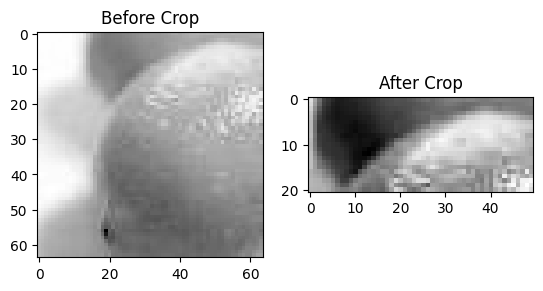

In [37]:
## Load images and convert to grayscale and resize
array_test_list=[]              
array_test_label=[]
array_selected_labels=[]
array_train_list=[]
array_train_label=[]

## For Test Data
for img in test_data:                ## Looping through each tuple which has image path and image label
    img_src,img_lab=img              ## Getting image path and its label as a list
    image = cv2.imread(img_src)
    coordi_key=img_src[59:]         ## Getting image name
    x_min, y_min, x_max, y_max=Img_coordinates[coordi_key] ## Getting image coordinates from Img_coordinates with image name as key
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   ## Convert BGR image to GRAY
    if x_max <= x_min or y_max <= y_min:                   ## If image coordinates are not in perfect dimension, assume original image size
        cropped_img=image_gray                             
        img_array=np.array(cropped_img)                    ## Converting image to array
        array_test_list.append(img_array)            
    else:
        cropped_img=image_gray[int(y_min):int(y_max), int(x_min):int(x_max)] ## Crop image as per the image dimensions
        img_array=np.array(cropped_img)                    ## Convert image to array
        array_test_list.append(img_array)                 
    if img_lab not in array_selected_labels:               ## Even if the label is not in the list, then add it for tracking
        array_selected_labels.append(img_lab)
    array_test_label.append(array_selected_labels.index(img_lab)) ## Get the index of the label and append it to array_test_label for testing purposes

## For Train Data 
for img in train_data:              ## Looping through each tuple which has image path and image label
    img_src,img_lab=img             ## Getting image path and its label as a list
    image = cv2.imread(img_src)
    coordi_key=img_src[59:]         ## Getting image name
    x_min, y_min, x_max, y_max=Img_coordinates[coordi_key]   ## Getting image coordinates from Img_coordinates with image name as key
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    ## Convert BGR image to GRAY

    if x_max <= x_min or y_max <= y_min:                    ## If image coordinates are not in perfect dimension, assume original image size
        cropped_img=image_gray
        img_array=np.array(cropped_img)                     ## Converting image to array
        array_train_list.append(img_array)
    else:
        cropped_img=image_gray[int(y_min):int(y_max), int(x_min):int(x_max)]    ## Crop image as per the image dimensions
        img_array=np.array(cropped_img)                     ## Convert image to array
        array_train_list.append(img_array)   
    if img_lab not in array_selected_labels:                ## Even if the label is not in the list, then add it for tracking
        array_selected_labels.append(img_lab)
    array_train_label.append(array_selected_labels.index(img_lab)) ## Get the index of the label and append it to array_train_label for testing purposes


print(f'Sample array of cropped image from array_train_list: \n{array_train_list[0]}\n')
print(f'Total length of array_train_list:{len(array_train_list)}\n')
print(f'Sample array of cropped image from array_test_list: \n{array_test_list[0]}\n')
print(f'Total length of array_test_list:{len(array_test_list)}\n\n')

## Plotting some images for better understanding of cropped images vs uncropped images
img_src,img_lab=train_data[1]           ## Getting image path and its label as a list
image = cv2.imread(img_src)             
coordi_key=img_src[59:]
x_min, y_min, x_max, y_max=Img_coordinates[coordi_key]  
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    ## Convert BGR image to GRAY
before_crop = image_gray
if x_max <= x_min or y_max <= y_min:    ## If image coordinates are not in perfect dimension, assume original image size
    cropped_img=image_gray  
else:
    cropped_img=image_gray[int(y_min):int(y_max), int(x_min):int(x_max)]
fullimg=image_gray

print("Sample Image Plotting:")
plt.subplot(1,2,1)
plt.imshow(fullimg, cmap='gray')        ## Plot before cropped image
plt.title("Before Crop")


plt.subplot(1,2,2)
plt.imshow(cropped_img, cmap='gray')    ## Plot after cropped image
plt.title("After Crop")


3.3 Full Image Dataset Preparation for Testing and Training

-> Similarly, the same process is applied to the full images, but without cropping. All other steps remain the same.

In [38]:
## Full Image
fullImg_array_test_list = []
fullImg_array_test_label = []
fullImg_array_selected_labels = []

fullImg_array_train_list = []
fullImg_array_train_label = []

# Test Data
for img in test_data:                   ## Looping through each tuple which has image path and image label 
    img_src, img_lab = img              ## Getting image path and its label as a list
    image = cv2.imread(img_src)         ## Read the image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    ## Convert BGR image to GRAY
    img_array = np.array(image_gray)    ## Converting full image to array
    fullImg_array_test_list.append(img_array)
    if img_lab not in fullImg_array_selected_labels:
        fullImg_array_selected_labels.append(img_lab)   ## Even if the label is not in the list, then add it for tracking
    fullImg_array_test_label.append(fullImg_array_selected_labels.index(img_lab))   ## Get the index of the label and append it to array_test_label for testing purposes


# Train Data
for img in train_data:                  ## Looping through each tuple which has image path and image label 
    img_src, img_lab = img              ## Getting image path and its label as a list
    image = cv2.imread(img_src)         ## Read the image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    ## Convert BGR image to GRAY
    img_array = np.array(image_gray)    ## Converting full image to array
    fullImg_array_train_list.append(img_array)
    if img_lab not in fullImg_array_selected_labels:
        fullImg_array_selected_labels.append(img_lab)    ## Even if the label is not in the list, then add it for tracking
    fullImg_array_train_label.append(fullImg_array_selected_labels.index(img_lab))  ## Get the index of the label and append it to array_train_label for training purposes

print(f'Sample array of full image from fullImg_array_train_list: \n{fullImg_array_train_list[0]}\n')
print(f'Total length of fullImg_array_train_list:{len(fullImg_array_train_list)}\n')
print(f'Sample array of full image from fullImg_array_test_list: \n{fullImg_array_test_list[0]}\n')
print(f'Total length of fullImg_array_test_list:{len(fullImg_array_test_list)}\n\n')


Sample array of full image from fullImg_array_train_list: 
[[210 209 209 ... 163 177 151]
 [209 210 212 ... 160 176 154]
 [211 213 216 ... 158 174 156]
 ...
 [172 186 198 ... 170 173 175]
 [166 176 182 ... 170 173 175]
 [165 168 165 ... 176 173 171]]

Total length of fullImg_array_train_list:6000

Sample array of full image from fullImg_array_test_list: 
[[ 28  61  60 ... 181 175 147]
 [ 21  84  66 ... 154 148 150]
 [ 45  77  59 ... 141 139 156]
 ...
 [199 253 244 ...   3  28   4]
 [238 208 252 ...   3  13   3]
 [220 251 221 ...  21   7  11]]

Total length of fullImg_array_test_list:1500




4. SIFT Feature Extraction

4.1 SIFT Extraction Loop for Cropped Images

-> This code extracts keypoints and descriptors from the cropped images and stores only the descriptors in SIFT_des_train and SIFT_des_test.

Sample SIFT Cropped Image Descriptors for training
 [[  5.   3.   0.   0.   0.   0.   0.   0.  91.  38.   1.   1.   0.   0.
    0.   1.  33.  14.   5.  74.  28.   3.   1.   1.   0.   0.  11.  82.
   13.   2.  10.   7.  66.  13.   0.   0.   0.   0.   0.  10. 202.  89.
    1.   1.   2.   1.   0.  53. 189.  17.   7.  42.  84.  34.   9.  13.
    0.   1.  24.  17.  13.  12.  41.  14.   9.   0.   0.   0.   0.   0.
    0.   6. 202.  30.   3.   4.   1.   0.   0.  82. 134.  35.  25.  91.
   68.  10.   2.  12.   0.   1.  99.  87.  19.   2.   2.   0.   0.   0.
    0.   0.   0.   0.   0.   0.  17.   3.   1.   1.   0.   1.   3.  13.
   14.   4.  16.  26.  70.  34.   8.  14.   0.   0.  15.  95. 122.  20.
    0.   0.]
 [ 29. 102.  10.   0.   0.   0.   0.   0.  55.  61.   3.   0.   0.   0.
    5.  26.  41.  57.   7.   4.   0.   3.  24.  43.  14.   5.   7.  15.
    1.   4.  12.  12.  58.  99.  21.   0.   0.   0.   0.   1. 126.  55.
   11.   7.   0.   0.  14.  98.  32.  19.  61.  47.   3.  15.  74.  91.

Text(0.5, 1.0, 'SIFT Keypoints on Cropped Image')

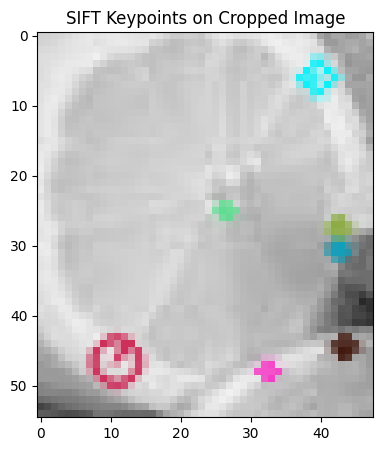

In [39]:
SIFT_des_train=[]               # Variable to store SIFT descriptors for training
SIFT_object=cv2.SIFT_create()   # Create SIFT object
for img_array in array_train_list:  ## Passing cropped images array through loop
    if img_array.ndim != 2 or img_array.size == 0 or img_array is None:
        SIFT_des_train.append(np.empty((0,128)))
        continue
    key_pt, des_pt=SIFT_object.detectAndCompute(img_array, None)    ## Using detectAndCompute function to get descriptors and keypoints
    SIFT_des_train.append(des_pt)

SIFT_des_test=[]            # Variable to store SIFT descriptors for testing
for img_array in array_test_list:    ## Passing cropped images array through loop
    if img_array.ndim != 2 or img_array.size == 0 or img_array is None: ## If dimensions are not correct, then append empty array with shape (0,128)
        SIFT_des_test.append(np.empty((0,128)))
        continue
    key_pt, des_pt=SIFT_object.detectAndCompute(img_array, None)    ## Using detectAndCompute function to get descriptors and keypoints
    SIFT_des_test.append(des_pt)

print("Sample SIFT Cropped Image Descriptors for training\n", SIFT_des_train[0])
print("\n\nSample SIFT Cropped Image Descriptors for testing\n", SIFT_des_test[0])

sample_descriptor=array_train_list[0]
keypoint, des = SIFT_object.detectAndCompute(sample_descriptor, None)
image_keypoint=cv2.drawKeypoints(sample_descriptor, keypoint, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(5,5))
plt.imshow(image_keypoint, cmap='gray')
plt.title("SIFT Keypoints on Cropped Image")


4.2 SIFT Extraction Loop for Full Images

-> The same process is applied to full images, and the descriptors are stored in fullImg_SIFT_des_train and fullImg_SIFT_des_test.

Sample SIFT full image descriptors for training
 [[ 7.  2.  0. ... 10.  0.  0.]
 [ 0.  0.  9. ...  4.  0.  0.]
 [27. 37.  3. ... 15. 34.  9.]
 ...
 [ 0.  0.  0. ... 31.  2.  5.]
 [ 1. 11. 70. ... 12.  0.  1.]
 [ 2.  0.  0. ...  0.  0. 57.]]


Sample SIFT full image descriptors for testing
 [[19. 23. 55. ...  0.  0.  0.]
 [39. 45. 35. ...  7. 15.  5.]
 [32. 20. 48. ...  0.  0.  0.]
 ...
 [41.  1.  1. ... 49.  4.  0.]
 [ 4.  2.  1. ... 47.  0.  0.]
 [23. 14.  5. ...  0.  0.  0.]]


Text(0.5, 1.0, 'SIFT Keypoints on Full Image')

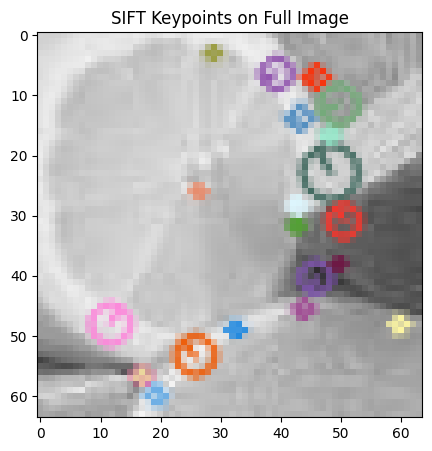

In [40]:
## SIFT descriptors for full image
fullImg_SIFT_des_train=[]       # Variable to store SIFT descriptors for training
fullImg_SIFT_object=cv2.SIFT_create()   # Create SIFT object
for img_array in fullImg_array_train_list:  ## Passing full image array through loop
    if img_array.ndim != 2 or img_array.size == 0 or img_array is None:
        fullImg_SIFT_des_train.append(np.empty((0,128)))
        continue
    key_pt, des_pt=fullImg_SIFT_object.detectAndCompute(img_array, None)
    fullImg_SIFT_des_train.append(des_pt)


fullImg_SIFT_des_test=[]                    # Variable to store SIFT descriptors for testing
for img_array in fullImg_array_test_list:   ## Passing full image array through loop
    if img_array.ndim != 2 or img_array.size == 0 or img_array is None: ## If dimensions are not correct, then append empty array with shape (0,128)
        fullImg_SIFT_des_test.append(np.empty((0,128)))
        continue
    key_pt, des_pt=fullImg_SIFT_object.detectAndCompute(img_array, None)    ## Using detectAndCompute function to get descriptors and keypoints
    fullImg_SIFT_des_test.append(des_pt)

print("Sample SIFT full image descriptors for training\n", fullImg_SIFT_des_train[0])
print("\n\nSample SIFT full image descriptors for testing\n", fullImg_SIFT_des_test[0])

sample_descriptor=fullImg_array_train_list[0]
keypoint, des = fullImg_SIFT_object.detectAndCompute(sample_descriptor, None)
image_keypoint=cv2.drawKeypoints(sample_descriptor, keypoint, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(5,5))
plt.imshow(image_keypoint, cmap='gray')
plt.title("SIFT Keypoints on Full Image")


5. ORB Feature Extraction

5.1 ORB Extraction Loop for Cropped Images

-> ORB descriptors are extracted and stored in ORB_des_train and ORB_des_test for cropped images.

In [41]:
ORB_des_train=[]                # Variable to store ORB descriptors for training

ORB_object=cv2.ORB_create()     # Create ORB object
for img_array in array_train_list:  ## Passing cropped images array through loop
    if img_array.ndim != 2 or img_array.shape[0] < 31 or img_array.shape[1] < 31  or img_array is None:     ## If dimensions are not correct, then append empty array with shape (0,32)
        ORB_des_train.append(np.empty((0,32)))
        continue
    key_pt, des_pt=ORB_object.detectAndCompute(img_array, None) ## Using detectAndCompute function to get descriptors and keypoints
    if des_pt is None:
        des_pt = np.empty((0,32), dtype=np.uint8)
    ORB_des_train.append(des_pt)

    
ORB_des_test=[]                 # Variable to store ORB descriptors for testing

for img_array in array_test_list:   ## Passing cropped images array through loop
    if img_array.ndim != 2 or img_array.shape[0] < 31 or img_array.shape[1] < 31  or img_array is None: ## If dimensions are not correct, then append empty array with shape (0,32)
        ORB_des_test.append(np.empty((0,32)))
        continue
    key_pt, des_pt=ORB_object.detectAndCompute(img_array, None) ## Using detectAndCompute function to get descriptors and keypoints
    if des_pt is None:
        des_pt = np.empty((0,32), dtype=np.uint8)
    ORB_des_test.append(des_pt)

print("Length of ORB_des_train:",len(ORB_des_train))
print("Length of ORB_des_test:",len(ORB_des_test))


Length of ORB_des_train: 6000
Length of ORB_des_test: 1500


5.2 ORB Extraction Loop for Full Images

-> The same process is applied to full images.

In [42]:
## For full images
fullImg_ORB_des_train=[]        # Variable to store ORB descriptors for training
fullImg_ORB_des_test=[]         # Variable to store ORB descriptors for testing
fullImg_ORB_object=cv2.ORB_create() # Create ORB object
for img_array in fullImg_array_train_list:  ## Passing full image array through loop
    if img_array.ndim != 2 or img_array.shape[0] < 31 or img_array.shape[1] < 31  or img_array is None:     ## If dimensions are not correct, then append empty array with shape (0,32)
        fullImg_ORB_des_train.append(np.empty((0,32)))
        continue
    key_pt, des_pt=fullImg_ORB_object.detectAndCompute(img_array, None)         ## Using detectAndCompute function to get descriptors and keypoints
    if des_pt is None:
        des_pt = np.empty((0,32), dtype=np.uint8)
    fullImg_ORB_des_train.append(des_pt)


for img_array in fullImg_array_test_list:   ## Passing full image array through loop
    if img_array.ndim != 2 or img_array.shape[0] < 31 or img_array.shape[1] < 31  or img_array is None:     ## If dimensions are not correct, then append empty array with shape (0,32)
        fullImg_ORB_des_test.append(np.empty((0,32)))
        continue
    key_pt, des_pt=fullImg_ORB_object.detectAndCompute(img_array, None)     ## Using detectAndCompute function to get descriptors and keypoints
    if des_pt is None:
        des_pt = np.empty((0,32), dtype=np.uint8)
    fullImg_ORB_des_test.append(des_pt)

print("Length of fullImg_ORB_des_train:",len(fullImg_ORB_des_train))
print("Length of fullImg_ORB_des_test:",len(fullImg_ORB_des_test))


Length of fullImg_ORB_des_train: 6000
Length of fullImg_ORB_des_test: 1500


6. Bag‑of‑Words (BoW)

6.1 KMeans clustering


6.1.1 Preparing Descriptors for K-Means for Both Full and Cropped Images

-> Now, stack all descriptors from both cropped and full images and store them in the empty list for use in k-means, skipping any empty descriptors.

In [43]:
## For cropped images
all_train_des_sift= []      ## Empty variable to store descriptors for all images for k-means
all_train_des_orb= []       ## Empty variable to store descriptors for all images for k-means
for des in SIFT_des_train:  
    if des is None:
        continue
    else:
        all_train_des_sift.append(des)
for des in ORB_des_train:
    if des is None:         ## If descriptor is None, then skip this instance of the loop to avoid null descriptors
        continue
    if des.shape[0] == 0:
        continue
    else:
        all_train_des_orb.append(des.astype(np.float32))
all_train_des_sift=np.vstack(all_train_des_sift)        ## vstack is used to stack all descriptors vertically
all_train_des_orb=np.vstack(all_train_des_orb)          ## vstack is used to stack all descriptors vertically
print(len(all_train_des_sift))
print(len(all_train_des_orb))


## For full images
fullImg_all_train_des_sift= []      ## Empty variable to store descriptors for all images for k-means
fullImg_all_train_des_orb= []       ## Empty variable to store descriptors for all images for k-means
for des in fullImg_SIFT_des_train:
    if des is None:
        continue
    else:
        fullImg_all_train_des_sift.append(des)
for des in fullImg_ORB_des_train:   
    if des is None:                 ## If descriptor is None, then skip this instance of the loop to avoid null descriptors
        continue
    if des.shape[0] == 0:
        continue
    else:
        fullImg_all_train_des_orb.append(des.astype(np.float32))
fullImg_all_train_des_sift=np.vstack(fullImg_all_train_des_sift)    ## vstack is used to stack all descriptors vertically
fullImg_all_train_des_orb=np.vstack(fullImg_all_train_des_orb)      ## vstack is used to stack all descriptors vertically


128635
271


6.1.2 Linear Visual Vocabulary for Both Full and Cropped Images

-> Using MiniBatchKMeans, create a visual vocabulary with 100 clusters by applying k-means clustering on the SIFT and ORB descriptors for both full and cropped images.

In [44]:
## For cropped images
k=100
## SIFT
kmeans_sift=MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42) ## Creating a k-means object for SIFT
kmeans_sift.fit(all_train_des_sift)
## ORB
kmeans_orb=MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)  ## Creating a k-means object for ORB
kmeans_orb.fit(all_train_des_orb)


## For full images
## SIFT
fullImg_kmeans_sift=MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42) ## Creating a k-means object for SIFT
fullImg_kmeans_sift.fit(fullImg_all_train_des_sift)
## ORB
fullImg_kmeans_orb=MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42) ## Creating a k-means object for ORB
fullImg_kmeans_orb.fit(fullImg_all_train_des_orb)


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.",100
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:'k-means++' : selects initial cluster centroids using sampling based onan empirical probability distribution of the points' contribution to theoverall inertia. This technique speeds up convergence. The algorithmimplemented is ""greedy k-means++"". It differs from the vanilla k-means++by making several trials at each sampling step and choosing the best centroidamong them.'random': choose `n_clusters` observations (rows) at random from datafor the initial centroids.If an array is passed, it should be of shape (n_clusters, n_features)and gives the initial centers.If a callable is passed, it should take arguments X, n_clusters and arandom state and return an initialization.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"max_iter max_iter: int, default=100Maximum number of iterations over the complete dataset beforestopping independently of any early stopping criterion heuristics.",100
,"batch_size batch_size: int, default=1024Size of the mini batches.For faster computations, you can set `batch_size > 256 * number_of_cores`to enable :ref:`parallelism `on all cores... versionchanged:: 1.0 `batch_size` default changed from 100 to 1024.",1000
,"verbose verbose: int, default=0Verbosity mode.",0
,"compute_labels compute_labels: bool, default=TrueCompute label assignment and inertia for the complete datasetonce the minibatch optimization has converged in fit.",True
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization andrandom reassignment. Use an int to make the randomness deterministic.See :term:`Glossary `.",42
,"tol tol: float, default=0.0Control early stopping based on the relative center changes asmeasured by a smoothed, variance-normalized of the mean centersquared position changes. This early stopping heuristics iscloser to the one used for the batch variant of the algorithmsbut induces a slight computational and memory overhead over theinertia heuristic.To disable convergence detection based on normalized centerchange, set tol to 0.0 (default).",0.0
,"max_no_improvement max_no_improvement: int, default=10Control early stopping based on the consecutive number of minibatches that does not yield an improvement on the smoothed inertia.To disable convergence detection based on inertia, setmax_no_improvement to None.",10
,"init_size init_size: int, default=NoneNumber of samples to randomly sample for speeding up theinitialization (sometimes at the expense of accuracy): theonly algorithm is initialized by running a batch KMeans on arandom subset of the data. This needs to be larger than n_clusters.If `None`, the heuristic is `init_size = 3 * batch_size` if`3 * batch_size < n_clusters`, else `init_size = 3 * n_clusters`.",None
,"n_init n_init: 'auto' or int, default=""auto""Number of random initializations that are tried.In contrast to KMeans, the algorithm is only run once, using the best ofthe `n_init` initializations as measured by inertia. Several runs arerecommended for sparse high-dimensional problems (see:ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:3 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'` in version.",'auto'


6.2 Building histograms

6.2.1 Function to Compute Bag-of-Words for Each Image Using SIFT and ORB

-> In this function, each image’s descriptors are assigned to the nearest cluster, and the count for each cluster is updated in the histogram.

In [45]:
def bagofwords_sift(img_des, kmeans_sift, k):   ## Created a function and passing the descriptors, fitted k-means for SIFT, and k with 100 as value
    bog_sift_hist = np.zeros(k)                 ## Creating a zero histogram 
    if img_des is None or len(img_des) == 0:
        return bog_sift_hist
    img_des = img_des.astype(np.float32)        ## Converting type to float32
    if img_des.ndim == 1:
        img_des = img_des.reshape(1,-1)        ## Reshape if not in proper shape
    cluster_points = kmeans_sift.predict(img_des) ## Predict which cluster each descriptor belongs to
    for cid in cluster_points:
        bog_sift_hist[cid] += 1                ## Add 1 for that particular occurrence in the histogram
    normalize = np.linalg.norm(bog_sift_hist)   
    if normalize > 0:
        bog_sift_hist = bog_sift_hist / normalize   ## Normalize to improve performance
    return bog_sift_hist                        ## Return the histogram


def bagofwords_orb(img_des, kmeans_orb, k):     ## Created a function and passing the descriptors, fitted k-means for ORB, and k with 100 as value
    bog_orb_hist = np.zeros(k)                  ## Creating a zero histogram
    if img_des is None or len(img_des) == 0:
        return bog_orb_hist
    img_des = img_des.astype(np.float32)        ## Converting type to float32
    if img_des.ndim == 1:
        img_des = img_des.reshape(1,-1)        ## Reshape if not in proper shape
    cluster_points = kmeans_orb.predict(img_des)  ## Predict which cluster each descriptor belongs to
    for cid in cluster_points:
        bog_orb_hist[cid] += 1                  ## Add 1 for that particular occurrence in the histogram
    normalize = np.linalg.norm(bog_orb_hist)
    if normalize > 0:
        bog_orb_hist = bog_orb_hist / normalize     ## Normalize to improve performance
    return bog_orb_hist                         ## Return the histogram


6.2.2 Pass Image Descriptors into the Bag-of-Words Function for SIFT to Build Histograms

-> This code applies bagofwords_sift to all SIFT descriptors, generating feature vectors ready for classification.

In [46]:
## SIFT Histogram for training with cropped images
all_bow_train_hist_sift=[]
for descriptor in SIFT_des_train:
    per_img_hist = bagofwords_sift(descriptor, kmeans_sift, k)  ## Passing the descriptor, kmeans_sift object, and k with value 100
    all_bow_train_hist_sift.append(per_img_hist)
all_bow_train_hist_sift = np.array(all_bow_train_hist_sift)    ## Converting it to a NumPy array
print("SIFT Histogram for training with cropped images:\n", all_bow_train_hist_sift[0])

## SIFT Histogram for training with full images
fullImg_all_bow_train_hist_sift=[]
for descriptor in fullImg_SIFT_des_train:
    per_img_hist = bagofwords_sift(descriptor, fullImg_kmeans_sift, k)
    fullImg_all_bow_train_hist_sift.append(per_img_hist)
fullImg_all_bow_train_hist_sift = np.array(fullImg_all_bow_train_hist_sift)
print("\n\nSIFT Histogram for training with full images:\n", fullImg_all_bow_train_hist_sift[0])

## SIFT Histogram for testing with cropped images
all_bow_test_hist_sift=[]
for descriptor in SIFT_des_test:
    per_img_hist = bagofwords_sift(descriptor, kmeans_sift, k)
    all_bow_test_hist_sift.append(per_img_hist)
all_bow_test_hist_sift = np.array(all_bow_test_hist_sift)
print("\n\nSIFT Histogram for testing with cropped images:\n", all_bow_test_hist_sift[0])

## SIFT Histogram for testing with full images
fullImg_all_bow_test_hist_sift=[]
for descriptor in fullImg_SIFT_des_test:
    per_img_hist = bagofwords_sift(descriptor, fullImg_kmeans_sift, k)
    fullImg_all_bow_test_hist_sift.append(per_img_hist)
fullImg_all_bow_test_hist_sift = np.array(fullImg_all_bow_test_hist_sift)
print("\n\nSIFT Histogram for testing with full images:\n", fullImg_all_bow_test_hist_sift[0])

SIFT Histogram for training with cropped images:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33333333 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.66666667 0.33333333 0.
 0.         0.33333333 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.   

6.2.3 Pass Image Descriptors into the Bag-of-Words Function for ORB to Build Histograms

-> This code applies bagofwords_orb to all ORB descriptors, generating feature vectors ready for classification.

In [47]:
## ORB Histogram for training with cropped Image
all_bow_train_hist_orb=[]
for desscriptor in ORB_des_train:
    per_img_hist= bagofwords_orb(desscriptor, kmeans_orb, k)    ##passing the descriptors, kmeans_sift object and k with value 100
    all_bow_train_hist_orb.append(per_img_hist)
all_bow_train_hist_orb=np.array(all_bow_train_hist_orb)         ##Converting it to an array

## ORB Histogram for training with Full Image
fullImg_all_bow_train_hist_orb=[]
for desscriptor in fullImg_ORB_des_train:
    per_img_hist= bagofwords_orb(desscriptor, fullImg_kmeans_orb, k)
    fullImg_all_bow_train_hist_orb.append(per_img_hist)
fullImg_all_bow_train_hist_orb=np.array(fullImg_all_bow_train_hist_orb)

## ORB Histogram for testing with cropped Image
all_bow_test_hist_orb=[]
for desscriptor in ORB_des_test:
    per_img_hist= bagofwords_orb(desscriptor, kmeans_orb, k)
    all_bow_test_hist_orb.append(per_img_hist)
all_bow_test_hist_orb=np.array(all_bow_test_hist_orb)


## ORB Histogram for testing with full Image
fullImg_all_bow_test_hist_orb=[]
for desscriptor in fullImg_ORB_des_test:
    per_img_hist= bagofwords_orb(desscriptor, kmeans_orb, k)
    fullImg_all_bow_test_hist_orb.append(per_img_hist)
fullImg_all_bow_test_hist_orb=np.array(fullImg_all_bow_test_hist_orb)

6.2.4 Training SVM

-> Trains SVMs on SIFT and ORB features for both cropped and full images, and then predicts the class labels on the testing dataset using the predict function.

In [48]:
## Converting histograms into arrays for both training and testing for SIFT cropped images
svm_bow_sift_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC(C=1.0, random_state=42))])
x_svm_sift_train = np.array(all_bow_train_hist_sift)
y_svm_sift_test = np.array(all_bow_test_hist_sift)
x_svm_sift_train_label = np.array(array_train_label)
y_svm_sift_test_label = np.array(array_test_label)

## Converting histograms into arrays for both training and testing for SIFT full images
fullImg_svm_bow_sift_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC(C=1.0, random_state=42))])
fullImg_x_svm_sift_train = np.array(fullImg_all_bow_train_hist_sift)
fullImg_y_svm_sift_test = np.array(fullImg_all_bow_test_hist_sift)
fullImg_x_svm_sift_train_label = np.array(fullImg_array_train_label)
fullImg_y_svm_sift_test_label = np.array(fullImg_array_test_label)

## Converting histograms into arrays for both training and testing for ORB cropped images
svm_bow_orb_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC(C=1.0, random_state=42))])
x_svm_orb_train = np.array(all_bow_train_hist_orb)  
y_svm_orb_test = np.array(all_bow_test_hist_orb)    
x_svm_orb_train_label = np.array(array_train_label)
y_svm_orb_test_label = np.array(array_test_label)

## Converting histograms into arrays for both training and testing for ORB full images
fullImg_svm_bow_orb_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', LinearSVC(C=1.0, random_state=42))])
fullImg_x_svm_orb_train = np.array(fullImg_all_bow_train_hist_orb)  
fullImg_y_svm_orb_test = np.array(fullImg_all_bow_test_hist_orb)    
fullImg_x_svm_orb_train_label = np.array(fullImg_array_train_label)
fullImg_y_svm_orb_test_label = np.array(fullImg_array_test_label)


## Train SVM using SIFT and ORB features with both cropped and full images, with their respective SVM objects
svm_bow_sift_pipeline.fit(x_svm_sift_train, x_svm_sift_train_label)        # Train SVM using Bag‑of‑Words SIFT features with cropped images and labels
svm_bow_orb_pipeline.fit(x_svm_orb_train, x_svm_orb_train_label)           # Train SVM using Bag‑of‑Words ORB features with cropped images and labels
fullImg_svm_bow_sift_pipeline.fit(fullImg_x_svm_sift_train, fullImg_x_svm_sift_train_label)  # Train SVM using Bag‑of‑Words SIFT features with full images and labels
fullImg_svm_bow_orb_pipeline.fit(fullImg_x_svm_orb_train, fullImg_x_svm_orb_train_label)     # Train SVM using Bag‑of‑Words ORB features with full images and labels


## Using the trained SVM model to predict the class label for testing images for both full and cropped images
svm_sift_predict = svm_bow_sift_pipeline.predict(y_svm_sift_test)
svm_orb_predict = svm_bow_orb_pipeline.predict(y_svm_orb_test)
fullImg_svm_sift_predict = fullImg_svm_bow_sift_pipeline.predict(fullImg_y_svm_sift_test)
fullImg_svm_orb_predict = fullImg_svm_bow_orb_pipeline.predict(fullImg_y_svm_orb_test)


6.2.5 Evaluating Accuracy of SVM for SIFT and ORB Features

In [49]:
svm_sift_accuracy = accuracy_score(y_svm_sift_test_label, svm_sift_predict) ## svm_sift_predict contains predicted classes and y_svm_sift_test_label contains the correct labels
print("SIFT cropped image accuracy:", svm_sift_accuracy)                      ## Print accuracy for SIFT cropped images

svm_orb_accuracy = accuracy_score(y_svm_orb_test_label, svm_orb_predict)     
print("ORB cropped image accuracy:", svm_orb_accuracy)                        ## Print accuracy for ORB cropped images

fullImg_svm_sift_accuracy = accuracy_score(fullImg_y_svm_sift_test_label, fullImg_svm_sift_predict)
print("SIFT full image accuracy:", fullImg_svm_sift_accuracy)                ## Print accuracy for SIFT full images

fullImg_svm_orb_accuracy = accuracy_score(fullImg_y_svm_orb_test_label, fullImg_svm_orb_predict)
print("ORB full image accuracy:", fullImg_svm_orb_accuracy)                  ## Print accuracy for ORB full images


SIFT cropped image accuracy: 0.23066666666666666
ORB cropped image accuracy: 0.06466666666666666
SIFT full image accuracy: 0.23733333333333334
ORB full image accuracy: 0.072


In [ ]:
## Best one is SIFT for cropped image. So, storing it as .pkl file
joblib.dump(svm_bow_sift_pipeline, "SIFT cropped image accuracy.pkl")

['SIFT cropped image accuracy.pkl']

7. Fisher Vector (SIFT & ORB) for cropped Images

-> Next is the Fisher Vector step, where all descriptors are converted to float32 arrays and a Gaussian Mixture Model (GMM) with 16 components is trained.

In [51]:
## Storing all the descriptors for training after converting type to float32
fisher_sift_des_float = []
for des in all_train_des_sift:
    if des is None or des.size == 0:          ## If descriptor is None or empty, store a zero descriptor
        des = np.zeros((1, 128), dtype="float32")
    if len(des.shape) != 2:
        des = des.reshape(1, -1)              ## Reshape if not 2D
    fisher_sift_des_float.append(des.astype("float32"))
        
k = 16
GMM_for_sift = learn_gmm(fisher_sift_des_float, n_modes=k)    ## Train a Gaussian Mixture Model (GMM) on the descriptors

## Likewise for ORB descriptors
fisher_orb_des_float = []
for des in all_train_des_orb:
    if des is None or des.size == 0:          ## If descriptor is None or empty, store a zero descriptor
        des = np.zeros((1, 128), dtype="float32")
    if len(des.shape) != 2:
        des = des.reshape(1, -1)              ## Reshape if not 2D
    fisher_orb_des_float.append(des.astype("float32"))
        
k = 16
GMM_for_orb = learn_gmm(fisher_orb_des_float, n_modes=k)       ## Train a Gaussian Mixture Model (GMM) on the descriptors


s:\Python\venv\Lib\site-packages\sklearn\mixture\_base.py:293: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


-> Here, all SIFT and ORB descriptors are converted into Fisher Vectors using the previously trained GMM.

In [52]:
##Convert each image SIFT descriptors into Fisher Vectors for training
fisher_vector_sift_train=[]
for des in SIFT_des_train:
    if des is None or des.size==0:
        des = np.zeros((1,128), dtype="float32")
    if len(des.shape)!=2:
        des = des.reshape(1, -1)
    des=des.astype("float32")
    fishervector=fisher_vector(des, GMM_for_sift)
    fisher_vector_sift_train.append(fishervector)
fisher_vector_sift_train=np.array(fisher_vector_sift_train)
print("Length of fisher_vector_sift_train:",len(fisher_vector_sift_train))

##Convert each image SIFT descriptors into Fisher Vectors for testing
fisher_vector_sift_test=[]
for des in SIFT_des_test:
    if des is None or des.size==0:
        des = np.zeros((1,128), dtype="float32")
    if len(des.shape)!=2:
        des = des.reshape(1, -1)
    des=des.astype("float32")
    fishervector=fisher_vector(des, GMM_for_sift)
    fisher_vector_sift_test.append(fishervector)
fisher_vector_sift_test=np.array(fisher_vector_sift_test)
print("Length of fisher_vector_sift_test:",len(fisher_vector_sift_test))

##Convert each image ORB descriptors into Fisher Vectors for training
fisher_vector_orb_train=[]
for des in ORB_des_train:
    if des is None or des.size==0:
        des = np.zeros((1,32), dtype="float32")
    if len(des.shape)!=2:
        des = des.reshape(1, -1)
    des=des.astype("float32")
    fishervector=fisher_vector(des, GMM_for_orb)
    fisher_vector_orb_train.append(fishervector)
fisher_vector_orb_train=np.array(fisher_vector_orb_train)
print("Length of fisher_vector_orb_train:",len(fisher_vector_orb_train))

##Convert each image ORB descriptors into Fisher Vectors for teating
fisher_vector_orb_test=[]
for des in ORB_des_test:
    if des is None or des.size==0:
        des = np.zeros((1,32), dtype="float32")
    if len(des.shape)!=2:
        des = des.reshape(1, -1)
    des=des.astype("float32")
    fishervector=fisher_vector(des, GMM_for_orb)
    fisher_vector_orb_test.append(fishervector)
fisher_vector_orb_test=np.array(fisher_vector_orb_test)
print("Length of fisher_vector_orb_test:",len(fisher_vector_orb_test))

Length of fisher_vector_sift_train: 6000
Length of fisher_vector_sift_test: 1500
Length of fisher_vector_orb_train: 6000
Length of fisher_vector_orb_test: 1500


-> Then, we train an SVM on the Fisher Vectors of SIFT descriptors and compute the accuracy (approximately 20 minites runtime)

In [53]:
## Accuracy of SIFT using Fisher Vectors

svm_sift = LinearSVC().fit(fisher_vector_sift_train, array_train_label)   ## Train SVM using Fisher Vectors of SIFT descriptors
prediction_sift = svm_sift.predict(fisher_vector_sift_test)              ## Predict class labels for test images
print("Fisher vector accuracy for SIFT:", accuracy_score(array_test_label, prediction_sift))  ## Compute and print accuracy

Fisher vector accuracy for SIFT: 0.24266666666666667


s:\Python\venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


-> Likewise, we train an SVM on the Fisher Vectors of ORB descriptors and compute the accuracy (approximately 20 minites runtime)

In [54]:
## Accuracy of ORB using Fisher Vectors

svm_orb = LinearSVC().fit(fisher_vector_orb_train, array_train_label)   ## Train SVM using Fisher Vectors of ORB descriptors
prediction_orb = svm_orb.predict(fisher_vector_orb_test)               ## Predict class labels for test images
print("Fisher vector accuracy for ORB:", accuracy_score(array_test_label, prediction_orb))  ## Compute and print accuracy


Fisher vector accuracy for ORB: 0.066


8. Accuracy Comparison Bar Plot

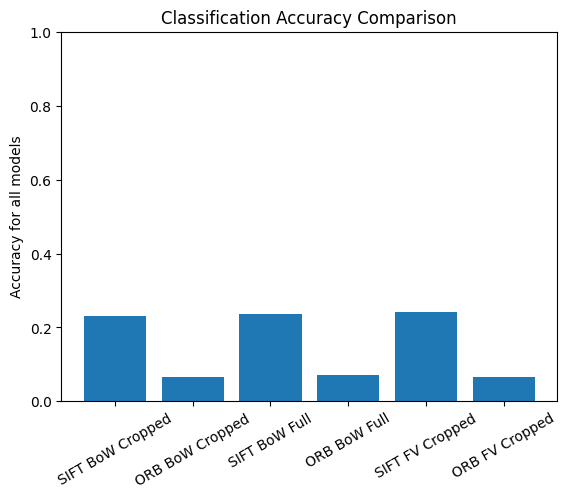

In [56]:
accuracy_barchart = {
    "SIFT BoW Cropped": svm_sift_accuracy,
    "ORB BoW Cropped": svm_orb_accuracy,
    "SIFT BoW Full": fullImg_svm_sift_accuracy,
    "ORB BoW Full": fullImg_svm_orb_accuracy,
    "SIFT FV Cropped": accuracy_score(array_test_label, prediction_sift),
    "ORB FV Cropped": accuracy_score(array_test_label, prediction_orb),
}
plt.bar(accuracy_barchart.keys(), accuracy_barchart.values())
plt.title("Classification Accuracy Comparison")
plt.ylabel("Accuracy for all models")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.show()

9. Conclution

Overall, it is clear that SIFT consistently performed better than ORB in all scenarios. After cropping the images, SIFT showed a slight improvement in accuracy compared to the full images, indicating that the model performs better when background noise is removed. ORB, on the other hand, showed low accuracy in both cases. In terms of Fisher Vector, SIFT achieved similar results compared to cropped SIFT images, while ORB’s performance remained low.

10. Reference 

References
- Bag of Words: The Foundation of Language Models. Medium. https://medium.com/data-science-collective/bag-of-words-the-foundation-of-language-models-cd22dec20c42
- Introduction to SIFT (Scale Invariant Feature Transform). Medium. https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40
- Detecting and Tracking Objects with ORB using OpenCV. Medium. https://medium.com/thedeephub/detecting-and-tracking-objects-with-orb-using-opencv-d228f4c9054e
- scikit-image Fisher Vector Encoding Example. https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_fisher_vector.html